In [43]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, random
import importlib
import numpy as np
from sklearn.metrics import make_scorer, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import Gradient_Boosting_Optimization
importlib.reload(Gradient_Boosting_Optimization) #Ensures file is uptodate!
from src.models.Gradient_Boosting_Optimization import Gradient_Boosting_Optimization

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [44]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test

(1174, 21)

In [45]:
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,5.0,2.0,0.0,22877.0,0.0,6.0,0.400000,3.0,9.0,1939.0,0.0,12.190200
1,5.0,2.0,0.0,22967.0,0.0,6.0,0.400000,5.0,9.0,1939.0,0.0,12.190200
2,7.0,4.0,0.0,21293.0,0.0,6.0,0.571429,5.0,9.0,1939.0,0.0,14.434062


In [46]:
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [47]:
#Feature Names for later feature analysis:
feature_names = list(df)
feature_names[:-1]

['Number of Ships',
 'Number of Escort Ships',
 'Number of Stragglers',
 'Total Tons of Convoy',
 'Overall Sink Percentage',
 'Avg Number of U-Boats in Atlantic',
 'Escort Ratio',
 'Time At Sea (Days)',
 'Month',
 'Year',
 'Previous Month Avg Sink %',
 'Approx. Sighting Range']


Best Hyperparameters Found:
{'learning_rate': 0.12, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.7}
Best Cross-Validation Score: 0.4677
Applied decision threshold: 0.3930 (F-beta: 0.9930)

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       185
           1       0.62      0.58      0.60        50

    accuracy                           0.83       235
   macro avg       0.75      0.74      0.75       235
weighted avg       0.83      0.83      0.83       235


ROC AUC Score: 0.8248
Matthews Correlation Coefficient (MCC): 0.4939
Balanced Accuracy: 0.7414
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          167           18
Actual 1           21           29
Recall (positive=1): 0.5800
F2 Score: 0.5870
False Negatives: 21

GradientBoostingClassifier Plots:



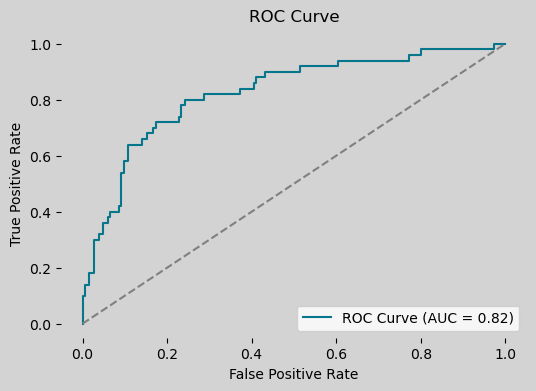

GradientBoostingClassifier Confusion Matrix Plot:


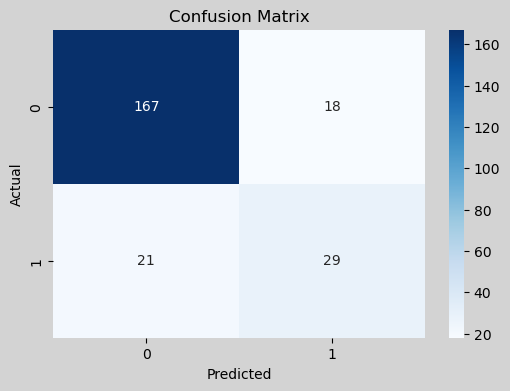

GradientBoostingClassifier Feature Importance Plot:


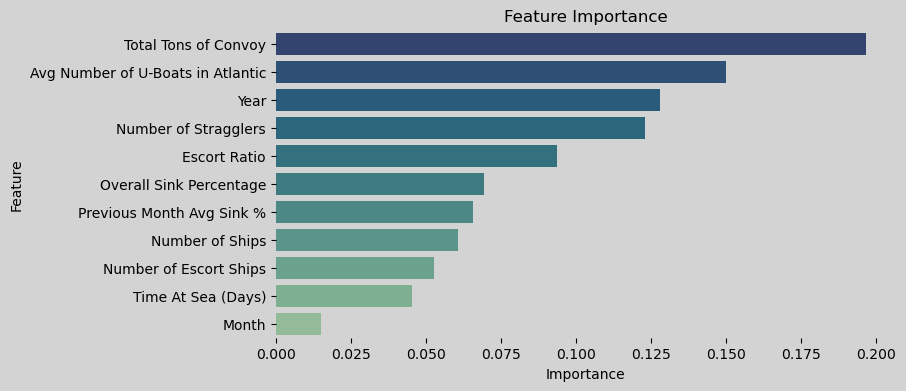

In [51]:
#Main Optimized Model:
#Gradient_Boosting_Optimization, grid-search & F2 threshold optimization
gb_grid = Gradient_Boosting_Optimization(
    model=GradientBoostingClassifier(random_state=1945),
    feature_names=feature_names,
    parameter_grid = {
        "learning_rate": [0.05, 0.08, 0.1, 0.12, 0.15],
        "n_estimators": [300, 320, 340, 360, 380],
        "max_depth": [3, 4, 5],
        "min_samples_leaf": [1, 2, 3, 5],
        "min_samples_split": [2, 3, 5],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["sqrt", "log2", None],},
    cv_folds=5,
    positive_label=1,
    optimize_scoring="recall",
    auto_calibrate_threshold=True,
    threshold_beta=2.0)

gb_grid.train_test_split(X, y, train_size=0.8, random_state=1945)
gb_grid.optimize()
gb_grid_results = gb_grid.evaluate(show_plots=True, save_plots=True)


In [49]:
#Manual Threshold Comparison using gb_grid: 
thresholds = np.arange(0, 1.05, 0.05) 
thresholds = thresholds.tolist() 
rows = []

for t in thresholds:
    gb_grid.set_decision_threshold(t)
    res = gb_grid.evaluate(show_plots=False, print_results=False)
    rows.append({
        "threshold": t,
        "recall": res["recall"],
        "precision": res["classification_report"]["1"]["precision"],
        "false_negatives": res["false_negatives"],
        "accuracy": res["classification_report"]["accuracy"],
        "f1-scores": res["classification_report"]["macro avg"]["f1-score"]
        })
gb_grid.set_decision_threshold(None) 
threshold_results = pd.DataFrame(rows)
threshold_results

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

,threshold,recall,precision,false_negatives,accuracy,f1-scores
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,0.86,0.361345,7,0.646809,0.616564
2,0.10,0.80,0.449438,10,0.748936,0.698646
3,0.15,0.72,0.480000,14,0.774468,0.711188
4,0.20,0.68,0.523077,16,0.800000,0.729455
5,0.25,0.64,0.551724,18,0.812766,0.735523
6,0.30,0.64,0.592593,18,0.829787,0.753047
7,0.35,0.60,0.600000,20,0.829787,0.745946
8,0.40,0.54,0.600000,23,0.825532,0.729544
9,0.45,0.46,0.575000,27,0.812766,0.697661


In [50]:
res

{'model_name': 'GradientBoostingClassifier',
 'classification_report': {'0': {'precision': 0.7872340425531915,
   'recall': 1.0,
   'f1-score': 0.8809523809523809,
   'support': 185.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 50.0},
  'accuracy': 0.7872340425531915,
  'macro avg': {'precision': 0.39361702127659576,
   'recall': 0.5,
   'f1-score': 0.44047619047619047,
   'support': 235.0},
  'weighted avg': {'precision': 0.6197374377546401,
   'recall': 0.7872340425531915,
   'f1-score': 0.6935157041540021,
   'support': 235.0}},
 'confusion_matrix': array([[185,   0],
        [ 50,   0]]),
 'roc_auc': 0.8247567567567567,
 'mcc': 0.0,
 'balanced_accuracy': 0.5,
 'recall': 0.0,
 'f2_score': 0.0,
 'decision_threshold': 1.0,
 'threshold_metric': 0.9930486593841087,
 'false_negatives': 50}

Applied decision threshold: 0.3000 (F-beta: 0.9930)

GradientBoostingClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       185
           1       0.59      0.64      0.62        50

    accuracy                           0.83       235
   macro avg       0.75      0.76      0.75       235
weighted avg       0.84      0.83      0.83       235


ROC AUC Score: 0.8248
Matthews Correlation Coefficient (MCC): 0.5069
Balanced Accuracy: 0.7605
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          163           22
Actual 1           18           32
Recall (positive=1): 0.6400
F2 Score: 0.6299
False Negatives: 18

GradientBoostingClassifier Plots:



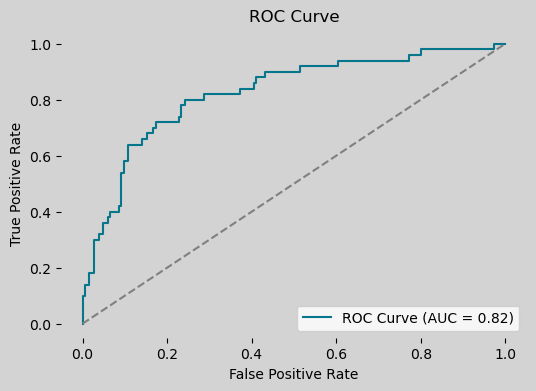

GradientBoostingClassifier Confusion Matrix Plot:


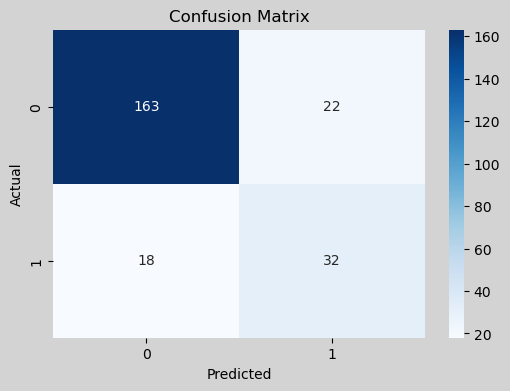

GradientBoostingClassifier Feature Importance Plot:


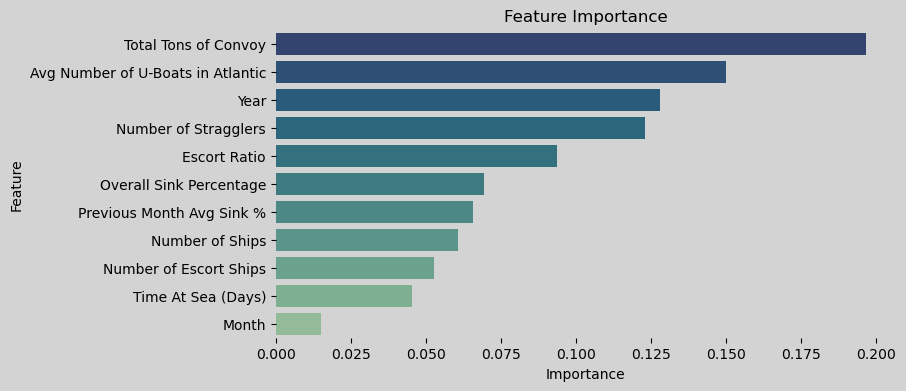

{'model_name': 'GradientBoostingClassifier',
 'classification_report': {'0': {'precision': 0.9005524861878453,
   'recall': 0.8810810810810811,
   'f1-score': 0.8907103825136612,
   'support': 185.0},
  '1': {'precision': 0.5925925925925926,
   'recall': 0.64,
   'f1-score': 0.6153846153846154,
   'support': 50.0},
  'accuracy': 0.8297872340425532,
  'macro avg': {'precision': 0.746572539390219,
   'recall': 0.7605405405405405,
   'f1-score': 0.7530474989491382,
   'support': 235.0},
  'weighted avg': {'precision': 0.8350291045718341,
   'recall': 0.8297872340425532,
   'f1-score': 0.8321304320606727,
   'support': 235.0}},
 'confusion_matrix': array([[163,  22],
        [ 18,  32]]),
 'roc_auc': 0.8247567567567567,
 'mcc': 0.5069206750377474,
 'balanced_accuracy': 0.7605405405405405,
 'recall': 0.64,
 'f2_score': 0.6299212598425197,
 'decision_threshold': 0.3,
 'threshold_metric': 0.9930486593841087,
 'false_negatives': 18}

In [53]:
# 0.30 has been determined to be best threshold as it has the highest accruacy and f1-score. 
gb_grid.set_decision_threshold(0.30)
gb_grid.evaluate(show_plots=True, save_plots=True, print_results=True)

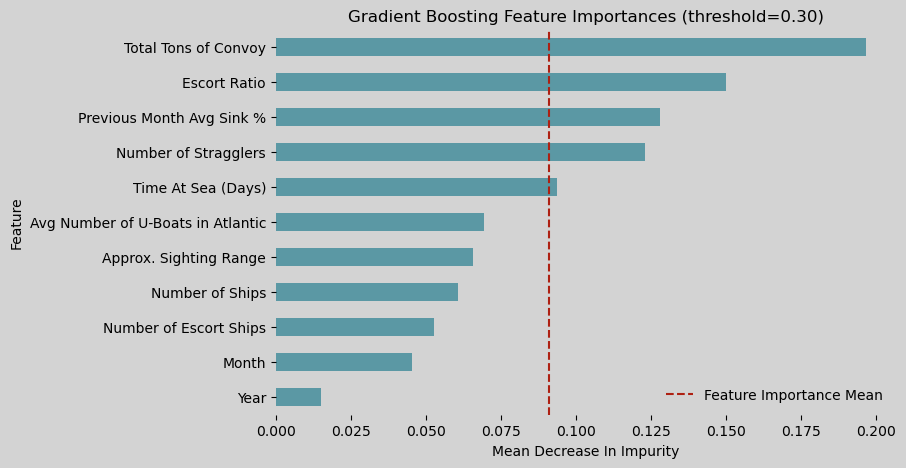

In [80]:
# Gradient Boosting feature importances for top features (threshold fixed at 0.30)
gb_grid.set_decision_threshold(0.30)
feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
X_train_df = pd.DataFrame(gb_grid.X_train, columns=feature_columns)
# Evaluate once to keep metrics aligned with the active threshold
gb_grid.evaluate(show_plots=False, print_results=False)
gb_importances = pd.Series(gb_grid.best_model.feature_importances_, index=feature_columns)
filtered = gb_importances[gb_importances > 0].sort_values().tail(15)
os.makedirs('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', exist_ok=True)
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
filtered.plot.barh(ax=ax, alpha=0.6, color='#0b7285', label='_nolegend_')
plt.axvline(gb_importances.mean(), c='#ae2012', linestyle='--', label='Feature Importance Mean')
ax.set_title('Gradient Boosting Feature Importances (threshold=0.30)')
ax.set_ylabel('Feature')
ax.set_xlabel('Mean Decrease In Impurity')
for spine in ax.spines.values():
    spine.set_visible(False)
plt.legend(loc='lower right', frameon=False)
output_path = os.path.join('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', 'gb_feature_importances.png')
# fig.savefig(output_path, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
plt.close(fig)


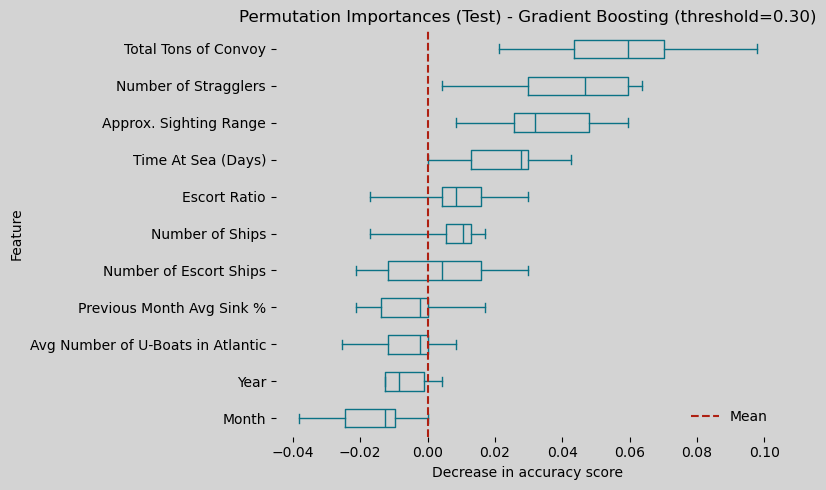

In [84]:
# Gradient Boosting permutation feature importances on test split (threshold fixed at 0.30)
from sklearn.inspection import permutation_importance

gb_grid.set_decision_threshold(0.30)
feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
X_test_df = pd.DataFrame(gb_grid.X_test, columns=feature_columns)
perm_result = permutation_importance(
    gb_grid.best_model,
    gb_grid.X_test,
    gb_grid.y_test,
    n_repeats=10,
    random_state=1945,
    n_jobs=2,
)
os.makedirs('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', exist_ok=True)
sorted_idx = perm_result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
importances = pd.DataFrame(
    perm_result.importances[sorted_idx].T,
    columns=X_test_df.columns[sorted_idx]
)
importances.plot.box(vert=False, whis=10, ax=ax, color='#0b7285')
ax.set_title('Permutation Importances (Test) - Gradient Boosting (threshold=0.30)')
ax.axvline(x=0, color='#ae2012', linestyle='--', label='Mean')
ax.set_xlabel('Decrease in accuracy score')
ax.set_ylabel('Feature')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, loc='lower right')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
fig.tight_layout()
output_path = os.path.join('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', 'gb_permutation_importances.png')
# fig.savefig(output_path, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
plt.close(fig)


/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_44307/560127081.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


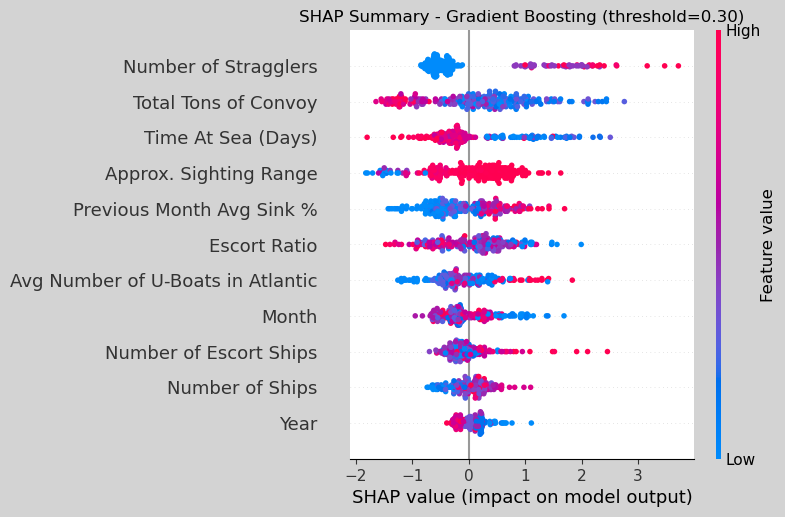

In [86]:
# SHAP summary (global view) for Gradient Boosting (threshold fixed at 0.30)
import shap

gb_grid.set_decision_threshold(0.30)
feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
X_test_df = pd.DataFrame(gb_grid.X_test, columns=feature_columns)
explainer = shap.TreeExplainer(gb_grid.best_model)
shap_values = explainer.shap_values(gb_grid.X_test)
os.makedirs('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', exist_ok=True)
shap.summary_plot(
    shap_values,
    X_test_df,
    feature_names=feature_columns,
    plot_type='dot',
    show=False
)
fig = plt.gcf()
fig.set_size_inches(8, 5)
fig.patch.set_facecolor('lightgrey')
for ax in fig.axes:
    ax.set_facecolor('lightgrey')
plt.title('SHAP Summary - Gradient Boosting (threshold=0.30)')
output_path = os.path.join('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', 'gb_shap_summary.png')
fig.savefig(output_path, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
plt.close(fig)


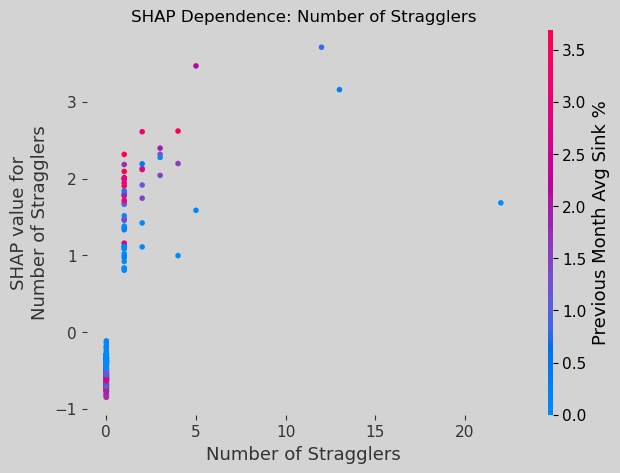

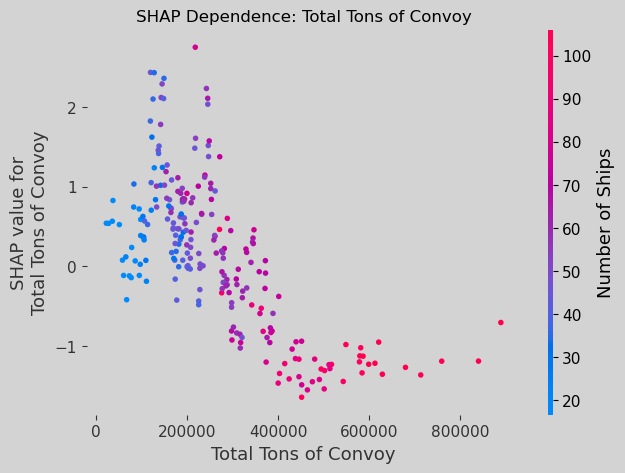

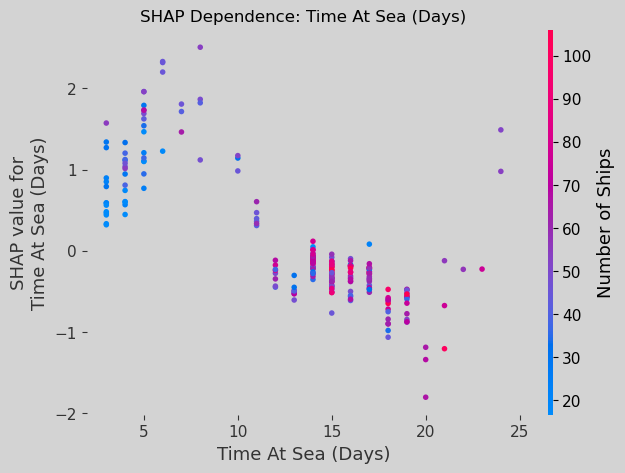

In [90]:
# SHAP dependence plots to inspect interactions (threshold fixed at 0.30)
feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
X_test_df = pd.DataFrame(gb_grid.X_test, columns=feature_columns)
os.makedirs('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', exist_ok=True)
top_features = np.argsort(np.abs(shap_values).mean(axis=0))[::-1][:3]
for idx in top_features:
    shap.dependence_plot(
        feature_columns[idx],
        shap_values,
        X_test_df,
        feature_names=feature_columns,
        interaction_index='auto',
        show=False
    )
    fig = plt.gcf()
    fig.patch.set_facecolor('lightgrey')
    fig.set_size_inches(7, 5)
    for ax in fig.axes:
        ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)    
    plt.title('SHAP Dependence: ' + feature_columns[idx])
    filename = 'gb_shap_dependence_' + feature_columns[idx].replace(' ', '_').replace('/', '') + '.png'
    output_path = os.path.join('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', filename)
    fig.savefig(output_path, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)


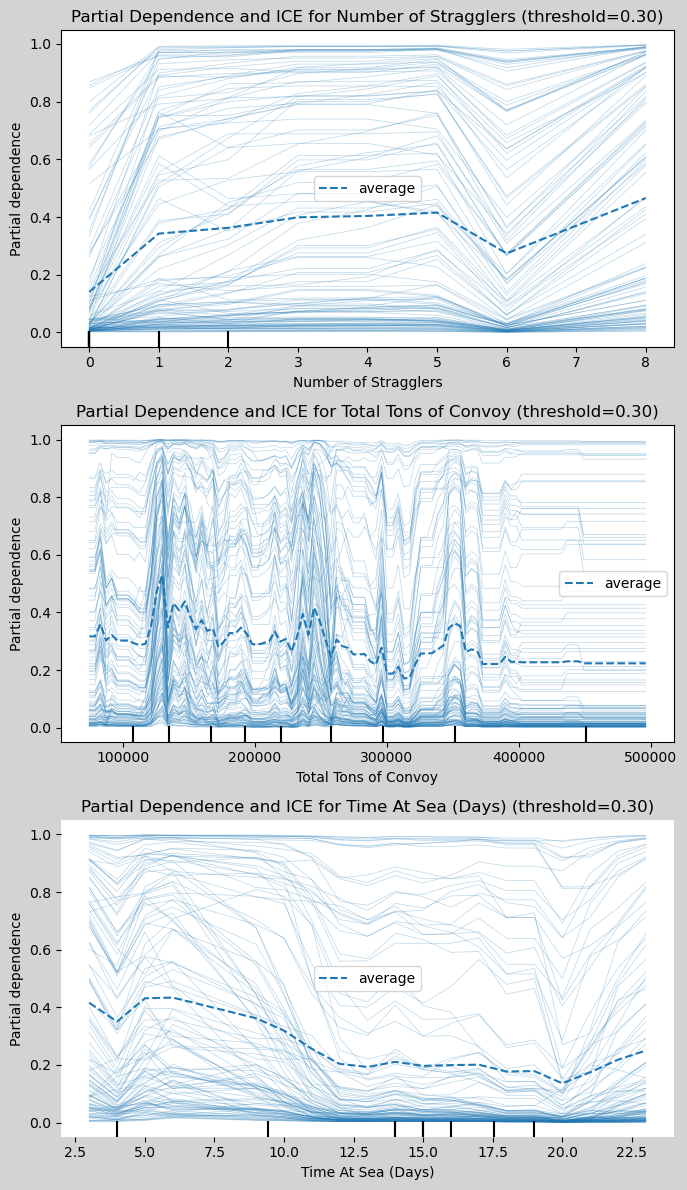

In [88]:
import warnings
from sklearn.inspection import PartialDependenceDisplay

feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
X_train_df = pd.DataFrame(gb_grid.X_train, columns=feature_columns)
features_to_probe = [feature_columns[i] for i in top_features]

# Sample a manageable subset so ICE curves stay interpretable
plot_sample = X_train_df.sample(n=min(120, len(X_train_df)), random_state=1945)
os.makedirs('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', exist_ok=True)

fig, ax = plt.subplots(len(features_to_probe), 1, figsize=(7, 4 * len(features_to_probe)), facecolor='lightgrey')
if len(features_to_probe) == 1:
    ax = [ax]

for i, feat in enumerate(features_to_probe):
    ax[i].set_facecolor('lightgrey')
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        PartialDependenceDisplay.from_estimator(
            gb_grid.best_model,
            plot_sample,
            features=[feat],
            kind='both',
            centered=False,
            ax=ax[i]
        )
    lines = ax[i].lines
    if lines:
        for line in lines[:-1]:
            line.set_alpha(0.25)
            line.set_linewidth(0.6)
            line.set_color('#94d2bd')
        lines[-1].set_color('#0b7285')
        lines[-1].set_linewidth(2)
    ax[i].set_title('Partial Dependence and ICE for ' + feat + ' (threshold=0.30)')
    ax[i].grid(alpha=0.2, linestyle='--')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
output_path = os.path.join('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots', 'gb_partial_dependence.png')
# fig.savefig(output_path, bbox_inches='tight', facecolor=fig.get_facecolor())
plt.show()
plt.close(fig)


In [70]:
# Create illustrative convoy scenarios to show concrete risk drivers (threshold fixed at 0.30)
feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
X_train_df = pd.DataFrame(gb_grid.X_train, columns=feature_columns)
quantiles = X_train_df.quantile([0.1, 0.5, 0.9])
low = quantiles.loc[0.1]
median = quantiles.loc[0.5]
high = quantiles.loc[0.9]

scenarios = []

def add_scenario(name, overrides):
    scenario = median.to_dict()
    scenario.update(overrides)
    scenario['Scenario'] = name
    scenarios.append(scenario)

add_scenario(
    "Baseline convoy (median conditions)",
    {}
)

add_scenario(
    "Highly protected large convoy",
    {
        'Number of Ships': high['Number of Ships'],
        'Number of Escort Ships': high['Number of Escort Ships'],
        'Avg Number of U-Boats in Atlantic': low['Avg Number of U-Boats in Atlantic'],
        'Previous Month Avg Sink %': low['Previous Month Avg Sink %'],
        'Approx. Sighting Range': high['Approx. Sighting Range'],
    }
)

add_scenario(
    "Sparse escorts under U-boat pressure",
    {
        'Number of Ships': high['Number of Ships'],
        'Number of Escort Ships': low['Number of Escort Ships'],
        'Avg Number of U-Boats in Atlantic': high['Avg Number of U-Boats in Atlantic'],
        'Previous Month Avg Sink %': high['Previous Month Avg Sink %'],
        'Escort Ratio': low['Escort Ratio'],
    }
)

add_scenario(
    "High straggler count",
    {
        'Number of Stragglers': high['Number of Stragglers'],
        'Number of Escort Ships': median['Number of Escort Ships'],
        'Escort Ratio': low['Escort Ratio'],
    }
)

add_scenario(
    "Long voyage with poor visibility",
    {
        'Time At Sea (Days)': high['Time At Sea (Days)'],
        'Approx. Sighting Range': low['Approx. Sighting Range'],
        'Avg Number of U-Boats in Atlantic': high['Avg Number of U-Boats in Atlantic'],
    }
)

scenario_df = pd.DataFrame(scenarios)

# Ensure all feature columns are present
scenario_df = scenario_df[['Scenario'] + list(feature_columns)]

# Score scenarios
gb_grid.set_decision_threshold(0.30)
probs = gb_grid.best_model.predict_proba(scenario_df[feature_columns])[:, 1]
scenario_df['Predicted Risk'] = probs
scenario_df['Risk Flag (threshold=0.30)'] = (probs >= gb_grid.decision_threshold).astype(int)

scenario_df[['Scenario', 'Predicted Risk', 'Risk Flag (threshold=0.30)']]


/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,Scenario,Predicted Risk,Risk Flag (threshold=0.30)
0,Baseline convoy (median conditions),0.014242,0
1,Highly protected large convoy,0.143589,0
2,Sparse escorts under U-boat pressure,0.971966,1
3,High straggler count,0.260441,0
4,Long voyage with poor visibility,0.006640,0


In [72]:
# Compare feature averages for actual sink vs. no-sink convoys in the held-out test split
gb_grid.set_decision_threshold(0.30)
feature_columns = df.drop(columns=['Overall Sink Percentage', 'Risk']).columns
test_eval_df = pd.DataFrame(gb_grid.X_test, columns=feature_columns)
test_eval_df['Actual Sink'] = gb_grid.y_test
predicted_probs = gb_grid.best_model.predict_proba(gb_grid.X_test)[:, 1]
test_eval_df['Predicted Probability'] = predicted_probs
test_eval_df['Predicted Flag'] = (predicted_probs >= gb_grid.decision_threshold).astype(int)
test_eval_df['Case Type'] = np.select(
    [
        (test_eval_df['Actual Sink'] == 1) & (test_eval_df['Predicted Flag'] == 1),
        (test_eval_df['Actual Sink'] == 0) & (test_eval_df['Predicted Flag'] == 1),
        (test_eval_df['Actual Sink'] == 1) & (test_eval_df['Predicted Flag'] == 0),
    ],
    ['True Positive', 'False Positive', 'False Negative'],
    default='True Negative'
)

feature_means = test_eval_df.groupby('Actual Sink')[feature_columns].mean().T.rename(columns={0: 'No Sink Avg', 1: 'Sink Avg'})
feature_means['Avg Diff (sink - no sink)'] = feature_means.get('Sink Avg', pd.Series(0, index=feature_means.index)) -     feature_means.get('No Sink Avg', pd.Series(0, index=feature_means.index))
feature_means.sort_values('Avg Diff (sink - no sink)', ascending=False).head(10)


Actual Sink,No Sink Avg,Sink Avg,Avg Diff (sink - no sink)
Number of Ships,58.010811,59.000000,0.989189
Previous Month Avg Sink %,0.996370,1.851440,0.855070
Number of Stragglers,0.443243,1.020000,0.576757
Approx. Sighting Range,23.359343,23.791007,0.431663
Time At Sea (Days),13.081081,13.320000,0.238919
Escort Ratio,0.247471,0.226233,-0.021238
Month,6.502703,6.460000,-0.042703
Year,1942.016216,1941.340000,-0.676216
Number of Escort Ships,14.729730,13.620000,-1.109730
Avg Number of U-Boats in Atlantic,39.535135,35.080000,-4.455135


In [75]:
# Inspect false negatives (missed sink events) with SHAP explanations to see what the model overlooked
if isinstance(shap_values, list):
    shap_array = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_array = shap_values

false_negatives = test_eval_df[test_eval_df['Case Type'] == 'False Negative']
if false_negatives.empty:
    print('No false negatives in the current test split.')
else:
    fn_indices = false_negatives.index
    fn_shap = pd.DataFrame(shap_array[fn_indices], columns=feature_columns, index=fn_indices)
    avg_fn_shap = fn_shap.mean().sort_values(ascending=False)
    display(false_negatives[['Predicted Probability', 'Predicted Flag']].join(false_negatives[feature_columns]).head())
    print('Average SHAP contribution among false negatives (positive = pushes risk higher):')
    display(avg_fn_shap.to_frame('Average SHAP Impact').head(10))


,Predicted Probability,Predicted Flag,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
11,0.129193,0,41.0,11.0,3.0,190736.0,45.0,0.268293,12.0,3.0,1942.0,1.974096,23.733944
82,0.060411,0,66.0,15.0,0.0,232049.0,35.0,0.227273,20.0,1.0,1942.0,0.348548,23.980900
91,0.052414,0,38.0,3.0,0.0,173171.0,5.0,0.078947,4.0,7.0,1940.0,1.120695,23.635040
101,0.012814,0,46.0,13.0,0.0,202522.0,15.0,0.282609,17.0,3.0,1941.0,2.951790,23.842897
106,0.032154,0,57.0,18.0,0.0,195397.0,32.0,0.315789,17.0,11.0,1941.0,1.410462,23.950699


Average SHAP contribution among false negatives (positive = pushes risk higher):


,Average SHAP Impact
Total Tons of Convoy,0.369123
Escort Ratio,0.112036
Year,0.069143
Number of Stragglers,0.054178
Number of Ships,0.034076
Approx. Sighting Range,-0.041759
Time At Sea (Days),-0.105999
Number of Escort Ships,-0.110205
Month,-0.164169
Avg Number of U-Boats in Atlantic,-0.171509


In [74]:
# Highlight the highest-risk convoys in the test split and their dominant SHAP contributors
if isinstance(shap_values, list):
    shap_array = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_array = shap_values

ranked_cases = test_eval_df.sort_values('Predicted Probability', ascending=False).head(5)
ranked_shap = pd.DataFrame(shap_array[ranked_cases.index], columns=feature_columns, index=ranked_cases.index)

def summarize_contributors(row):
    sorted_row = row.sort_values()
    negatives = ', '.join(sorted_row.head(3).index)
    positives = ', '.join(sorted_row.tail(3).index)
    return pd.Series({'Top Positive Contributors': positives, 'Top Negative Contributors': negatives})

shap_summary = ranked_shap.apply(summarize_contributors, axis=1)
ranked_cases[['Actual Sink', 'Predicted Probability', 'Predicted Flag', 'Case Type']].join(shap_summary)


,Actual Sink,Predicted Probability,Predicted Flag,Case Type,Top Positive Contributors,Top Negative Contributors
117,1,0.997660,1,True Positive,"Time At Sea (Days), Total Tons of Convoy, Numb...","Escort Ratio, Number of Escort Ships, Approx. ..."
99,1,0.995141,1,True Positive,"Previous Month Avg Sink %, Total Tons of Convo...","Time At Sea (Days), Number of Escort Ships, Ap..."
164,1,0.992800,1,True Positive,"Total Tons of Convoy, Month, Number of Stragglers","Avg Number of U-Boats in Atlantic, Number of E..."
169,1,0.990691,1,True Positive,"Total Tons of Convoy, Previous Month Avg Sink ...","Time At Sea (Days), Number of Escort Ships, Av..."
52,1,0.978643,1,True Positive,"Previous Month Avg Sink %, Total Tons of Convo...","Number of Stragglers, Month, Year"
